
--- Training CNN DistNet ---
CNN DistNet - After 1 ep (lr=5.00e-04): avg loss 8.17e-01 ; test acc 91.96% (error: 8.04%)
CNN DistNet - After 2 ep (lr=4.94e-04): avg loss 2.86e-01 ; test acc 94.04% (error: 5.96%)
CNN DistNet - After 3 ep (lr=4.76e-04): avg loss 2.20e-01 ; test acc 95.64% (error: 4.36%)
CNN DistNet - After 4 ep (lr=4.46e-04): avg loss 1.91e-01 ; test acc 95.92% (error: 4.08%)
CNN DistNet - After 5 ep (lr=4.05e-04): avg loss 1.74e-01 ; test acc 96.21% (error: 3.79%)
CNN DistNet - After 6 ep (lr=3.54e-04): avg loss 1.61e-01 ; test acc 96.65% (error: 3.35%)
CNN DistNet - After 7 ep (lr=2.94e-04): avg loss 1.51e-01 ; test acc 96.76% (error: 3.24%)
CNN DistNet - After 8 ep (lr=2.27e-04): avg loss 1.43e-01 ; test acc 96.81% (error: 3.19%)
CNN DistNet - After 9 ep (lr=1.55e-04): avg loss 1.36e-01 ; test acc 97.05% (error: 2.95%)
CNN DistNet - After 10 ep (lr=7.82e-05): avg loss 1.30e-01 ; test acc 97.01% (error: 2.99%)


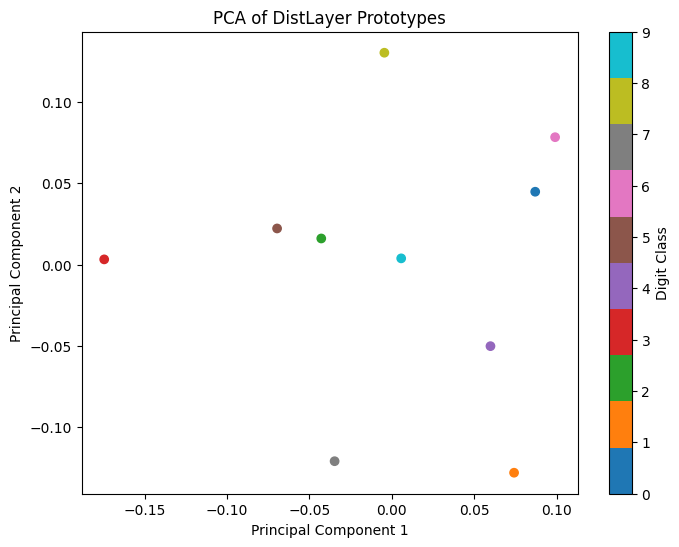

C:\Users\Nelathan\AppData\Local\Temp\ipykernel_23052\2000986000.py:150: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if dummy_input.grad is not None:
C:\Users\Nelathan\AppData\Local\Temp\ipykernel_23052\2000986000.py:157: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor.

AttributeError: 'NoneType' object has no attribute 'data'

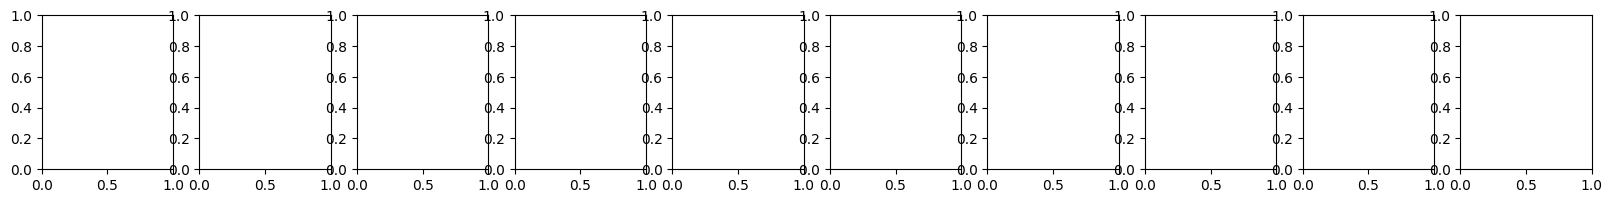

In [8]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.decomposition import PCA

# --- Data Loading ---
train_data = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)

IN_FEATURES = 28 * 28
OUT_FEATURES = 10
BATCH_SIZE = 32
N_EPOCH = 10

LEARNING_RATE = 5e-4
H_EXP = -4.5
WEIGHT_DECAY = 0.002

# Normalize to [-1, 1]
Xtr = (train_data.data.reshape(-1, IN_FEATURES).to(torch.float32) / 127.5 - 1.0)
Xte = (test_data.data.reshape(-1, IN_FEATURES).to(torch.float32) / 127.5 - 1.0)
Ytr = train_data.targets
Yte = test_data.targets

xent = nn.CrossEntropyLoss()

# --- DistLayer Definition ---
class DistLayer(torch.nn.Linear):
    def __init__(self, in_features, out_features, eps=1e-4):
        super(DistLayer, self).__init__(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x):
        # x: (B, N), self.weight: (V, N)
        diff = x[:, None, :] - self.weight[None, :, :]  # (B, V, N)
        dist_sq = torch.sum(diff * diff, dim=-1)  # (B, V)
        dist_sq += self.eps
        dist_sq /= torch.min(dist_sq, dim=-1, keepdim=True)[0]
        return dist_sq

# --- CNN Models with Extra Linear Layer ---
# EfficientDistNet now has an extra linear layer (fc_extra) before the DistLayer.
class EfficientDistNet(nn.Module):
    def __init__(self, out_features, eps=1e-4):
        super(EfficientDistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False, groups=32)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        # self.fc_extra = DistLayer(64, 64, eps=eps)
        self.dist = DistLayer(64, out_features, eps=eps)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # (B, 1, 28, 28)
        x = F.silu(self.bn1(self.conv2(F.silu(self.conv1(x)))))
        x = F.silu(self.bn2(self.conv4(F.silu(self.conv3(x)))))
        x = self.pool(x).view(x.shape[0], -1)  # (B, 64)
        # x = F.silu(self.fc_extra(x))
        return self.dist(x)

# EfficientStandardNet now also gets an extra linear layer.
class EfficientStandardNet(nn.Module):
    def __init__(self, out_features):
        super(EfficientStandardNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False, groups=32)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        # self.fc_extra = nn.Linear(64, 64)      # NEW: Extra linear layer
        self.fc = nn.Linear(64, out_features)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # (B, 1, 28, 28)
        x = F.silu(self.bn1(self.conv2(F.silu(self.conv1(x)))))
        x = F.silu(self.bn2(self.conv4(F.silu(self.conv3(x)))))
        x = self.pool(x).view(x.shape[0], -1)  # (B, 64)
        # x = F.silu(self.fc_extra(x))
        return self.fc(x)

# --- Visualization Functions ---
# PCA on DistLayer prototypes remains as-is.
def visualize_dist_pca(model):
    for layer in model.modules():
        if isinstance(layer, DistLayer):
            weights = layer.weight.detach().cpu().numpy()
            pca = PCA(n_components=2)
            reduced_weights = pca.fit_transform(weights)

            plt.figure(figsize=(8, 6))
            plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=range(10), cmap='tab10')
            plt.colorbar(label='Digit Class')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA of DistLayer Prototypes')
            plt.show()

# Old visualization that multiplies weight matrices works only for pure linear layers.
# We now add a CNN-specific version using a gradient-based saliency map.
def visualize_activation_maps(model, in_features, out_features):
    # If the model uses any conv layers, use the CNN visualization.
    if any(isinstance(m, nn.Conv2d) for m in model.modules()):
        visualize_activation_maps_cnn(model)
    else:
        # Fallback (not expected to hit this branch for our CNNs)
        combined_weights = None
        for layer in model.modules():
            if isinstance(layer, nn.Linear) and not isinstance(layer, DistLayer):
                if combined_weights is None:
                    combined_weights = layer.weight
                else:
                    combined_weights = torch.matmul(layer.weight, combined_weights)
            elif isinstance(layer, DistLayer):
                combined_weights = torch.matmul(layer.weight, combined_weights)
        if combined_weights is not None:
            fig = plt.figure(figsize=(15, 3))
            ig = ImageGrid(fig, 111, (1, out_features))
            for i, ax in enumerate(ig.axes_all):
                ax.axis('off')
                image = combined_weights[i].reshape(int(np.sqrt(in_features)), int(np.sqrt(in_features))).cpu().numpy()
                lim = np.abs(image).max()
                ax.imshow(image, vmin=-lim, vmax=lim, cmap='coolwarm')
                ax.set_title(f"Digit {i}")
            plt.show()

def visualize_activation_maps_cnn(model, num_classes=10):
    """
    Uses a dummy input and computes gradients of each class output with respect
    to the input image. The resulting "saliency" map shows the influence of each pixel.
    """
    # model.eval()
    # Use a baseline input; zeros work fine given our normalization (-1 to 1)
    dummy_input = torch.zeros((1, 1, 28, 28), requires_grad=True).cuda()
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))
    for i in range(num_classes):
        model.zero_grad()
        if dummy_input.grad is not None:
            dummy_input.grad.zero_()
        output = model(dummy_input)
        # For DistNet the lower the distance, the stronger the match.
        score = -output[0, i] if hasattr(model, 'dist') else output[0, i]
        score.backward(retain_graph=True)
        # Take the maximum gradient across the channel dimension (should be 1 channel anyway)
        saliency, _ = torch.max(dummy_input.grad.data.abs(), dim=1)
        saliency = saliency.squeeze().cpu().numpy()
        axes[i].imshow(saliency, cmap='hot')
        axes[i].set_title(f"Class {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    # model.train()

# --- Training Function ---
def train_and_evaluate(model, optimizer, criterion, harmonic_exponent=None, visualize=False, model_name=""):
    scaler = torch.amp.GradScaler('cuda')
    losses = []
    test_accuracies = []

    for ep in range(N_EPOCH):
        # Cosine learning rate schedule
        lr = LEARNING_RATE * np.cos(ep / N_EPOCH * np.pi / 2)
        for group in optimizer.param_groups:
            group['lr'] = lr

        epoch_losses = []
        indices = torch.randperm(len(Xtr))
        for b0 in range(0, len(Xtr), BATCH_SIZE):
            x = Xtr[indices[b0:b0+BATCH_SIZE]].cuda()
            y = Ytr[indices[b0:b0+BATCH_SIZE]].cuda()
            optimizer.zero_grad()

            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                if harmonic_exponent is not None:  # For DistNet
                    ds = model(x)
                    dinv = ds ** harmonic_exponent
                    probs = dinv / torch.sum(dinv, dim=-1, keepdim=True)
                    logits = -torch.log(probs)
                    loss = logits[range(y.size(0)), y].mean()
                else:  # StandardNet
                    logits = model(x)
                    loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))

        corrects = []
        for i0 in range(0, len(Xte), 128):
            with torch.no_grad():
                if harmonic_exponent is not None:
                    preds = model(Xte[i0:i0+128].cuda()).argmin(1)  # DistNet: lower distance → better match
                else:
                    preds = model(Xte[i0:i0+128].cuda()).argmax(1)
                corrects.extend((preds == Yte[i0:i0+128].cuda()).cpu().tolist())
        test_acc = np.mean(corrects)
        test_accuracies.append(test_acc)

        lr = optimizer.param_groups[0]['lr']
        print(f'{model_name} - After {ep+1} ep (lr={lr:.2e}): avg loss {np.mean(epoch_losses):.2e} ; test acc {test_acc:.2%} (error: {1-test_acc:.2%})')

    if visualize:
        # For CNN models, our new saliency-based activation maps work regardless of harmonic_exponent.
        visualize_dist_pca(model)
        visualize_activation_maps(model, IN_FEATURES, OUT_FEATURES)

    return losses, test_accuracies

# --- DistNet (CNN with DistLayer) ---
print("\n--- Training CNN DistNet ---")
dist_model = EfficientDistNet(OUT_FEATURES).cuda()
dist_optimizer = torch.optim.AdamW(dist_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dist_losses, dist_accuracies = train_and_evaluate(dist_model, dist_optimizer, None,
                                                  harmonic_exponent=H_EXP,
                                                  visualize=True, model_name="CNN DistNet")

# --- StandardNet (CNN with final fc) ---
print("\n--- Training CNN StandardNet ---")
standard_model = EfficientStandardNet(OUT_FEATURES).cuda()
standard_optimizer = torch.optim.AdamW(standard_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
standard_losses, standard_accuracies = train_and_evaluate(standard_model, standard_optimizer, xent,
                                                          harmonic_exponent=None,
                                                          visualize=True, model_name="CNN StandardNet")

# --- Plot Results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(dist_losses, label="CNN DistNet")
axes[0].plot(standard_losses, label="CNN StandardNet")
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(dist_accuracies, label="CNN DistNet")
axes[1].plot(standard_accuracies, label="CNN StandardNet")
axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Print Summary ---
print("\n--- Summary ---")
print(f"CNN DistNet: Best Accuracy: {max(dist_accuracies):.4f}, Final Loss: {dist_losses[-1]:.4f}")
print(f"CNN StandardNet: Best Accuracy: {max(standard_accuracies):.4f}, Final Loss: {standard_losses[-1]:.4f}")
